In [7]:
import numpy as np
import pandas as pd
import nlpaug.augmenter.word as naw
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Loading data
df = pd.read_csv('Data\\balanced_augmented_Call_Conversation(Emotion).csv')
print(df.shape)

(602, 4)


In [41]:
df.head(3)

,VoiceClip_No,TextTranscript,label,processed_content
0,Voice49,check let know last day done payment much pay,Non,check let know last day done payment much pay
1,Voice237,indicated one light working earlier bulbs work...,Non,indicated one light working earlier bulbs work...
2,Voice99,know get physical bills anymore,Non,know get physical bills anymore


In [42]:
x = df['TextTranscript']
y = df['label']

In [197]:

X_train, X_test, y_train, y_test = train_test_split(df['TextTranscript'], df['label'], test_size=0.2, random_state=42)

Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 300}

Classification Report for Random Forest on Testing Data:
              precision    recall  f1-score   support

         Agg       0.93      0.84      0.88        63
         Non       0.84      0.93      0.89        58

    accuracy                           0.88       121
   macro avg       0.89      0.89      0.88       121
weighted avg       0.89      0.88      0.88       121



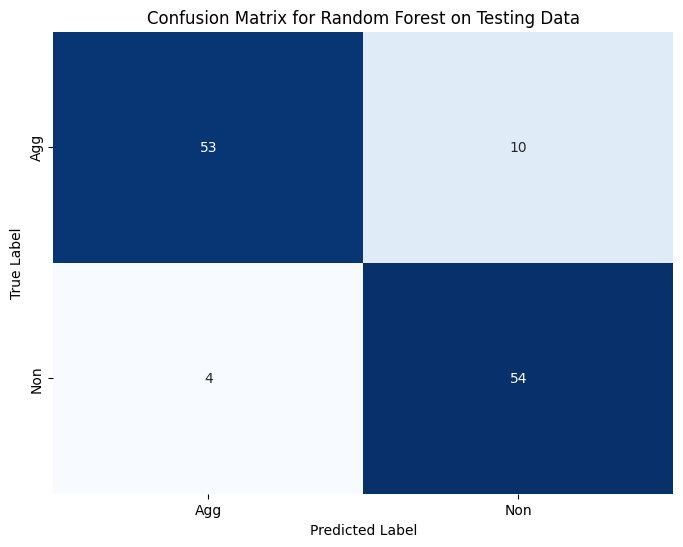

In [207]:

# TF-IDF Vectorization (converts the text data(comments) into numerical features)
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Hyperparameter grid to search
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
    'min_samples_split': [5,10,20],  # Minimum samples required to split a node
    'min_samples_leaf': [10,15]  # Minimum samples required at a leaf node
}

# Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with cross-validation on the training data to find the best hyperparameters
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=kf)
grid_search_rf.fit(X_train_tfidf, y_train)

# Best hyperparameters from the grid search
best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters for Random Forest:", best_params_rf)

# Train the final Random Forest model with the best hyperparameters
final_rf_classifier = RandomForestClassifier(**best_params_rf, random_state=42)
final_rf_classifier.fit(X_train_tfidf, y_train)



# Evaluate the final Random Forest model on the testing dataset
report_rf = classification_report(y_test, y_pred_rf)
print("\nClassification Report for Random Forest on Testing Data:")
print(report_rf)

# Compute the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=final_rf_classifier.classes_,
            yticklabels=final_rf_classifier.classes_)
plt.title('Confusion Matrix for Random Forest on Testing Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [208]:
# Predict class labels on the training dataset
y_train_pred_rf = final_rf_classifier.predict(X_train_tfidf)

# Predict class labels on the testing dataset
y_test_pred_rf = final_rf_classifier.predict(X_test_tfidf)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
print(f'\nTraining Accuracy: {train_accuracy:.4f}')

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_rf)
print(f'TestingAccuracy: {test_accuracy:.4f}')


Training Accuracy: 0.7983
TestingAccuracy: 0.7107


Model overfiitng
